In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [34]:
movies = pd.read_parquet('../Datasets/movies.parquet')
casting = pd.read_parquet('../Datasets/union_mcasting.parquet')
crew = pd.read_parquet('../Datasets/union_mcrew.parquet')

### Verificamos si hay outliiers o anomalias en los df
* df movies

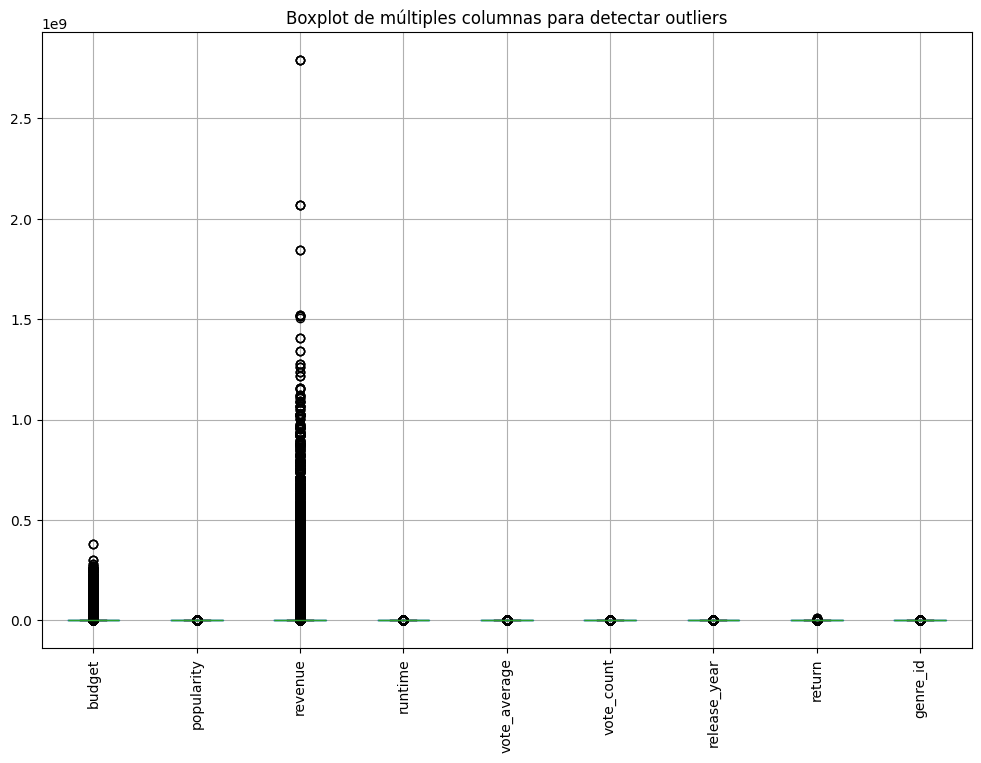

In [35]:
movies.boxplot(figsize=(12, 8))
plt.xticks(rotation=90)
plt.title('Boxplot de múltiples columnas para detectar outliers')
plt.show()

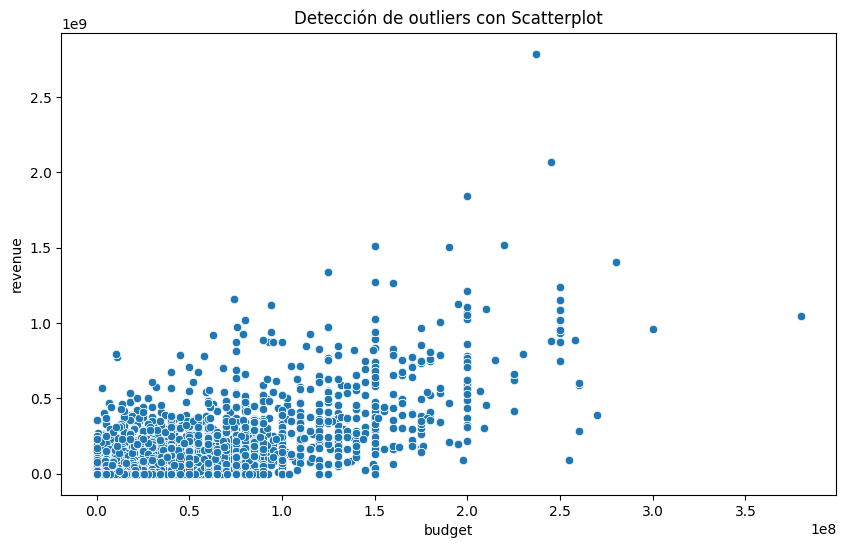

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget', y='revenue', data=movies)
plt.title('Detección de outliers con Scatterplot')
plt.show()

In [37]:
# Calcular Z-Score
movies['z_score'] = stats.zscore(movies['revenue'])

# Identificar outliers
outliers = movies[movies['z_score'].abs() > 3]
print(outliers)

            budget id_movie  popularity release_date      revenue  runtime  \
0       30000000.0      862   21.946943   1995-10-30  373554033.0     81.0   
1       30000000.0      862   21.946943   1995-10-30  373554033.0     81.0   
2       30000000.0      862   21.946943   1995-10-30  373554033.0     81.0   
3       65000000.0     8844   17.015539   1995-12-15  262797249.0    104.0   
4       65000000.0     8844   17.015539   1995-12-15  262797249.0    104.0   
...            ...      ...         ...          ...          ...      ...   
92080  100000000.0   374720   30.938854   2017-07-19  519876949.0    107.0   
92352  260000000.0   335988   39.186819   2017-06-21  604942143.0    149.0   
92353  260000000.0   335988   39.186819   2017-06-21  604942143.0    149.0   
92354  260000000.0   335988   39.186819   2017-06-21  604942143.0    149.0   
92355  260000000.0   335988   39.186819   2017-06-21  604942143.0    149.0   

                               title  vote_average  vote_count 

##  Analisis Financiero

In [43]:
# las 10 películas con mayor retorno
top_return_movies = (movies.groupby('title', as_index=False)
                            .agg({'return': 'max'})
                            .nlargest(10, 'return'))

# Similar para ganancia
movies['profit'] = movies['revenue'] - movies['budget']
top_profit_movies = (movies.groupby('title', as_index=False)
                    .agg({'profit': 'max'})
                    .nlargest(20, 'profit'))
bottom_profit_movies = (movies.groupby('title', as_index=False)
                        .agg({'profit': 'min'})
                        .nsmallest(20, 'profit'))

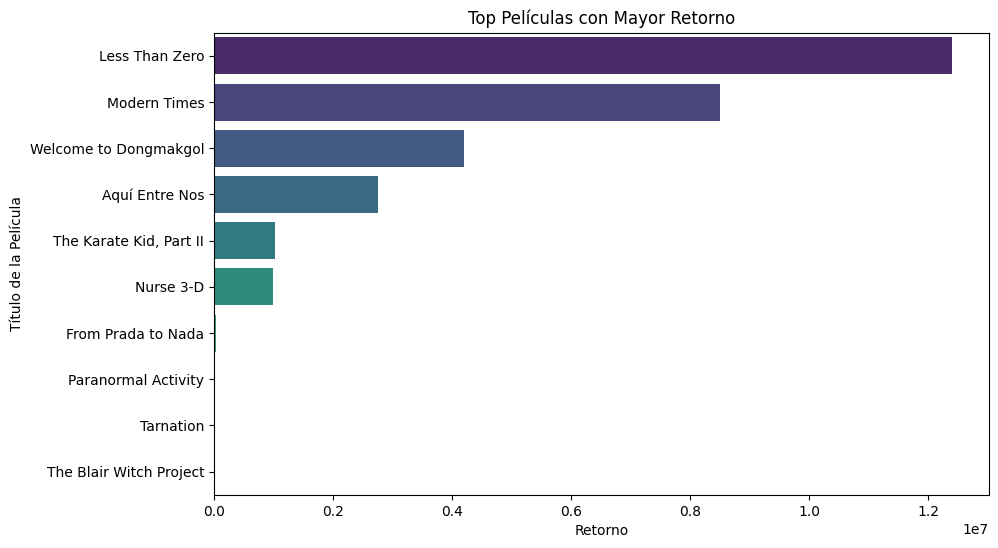

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x='return', y='title', data=top_return_movies, palette='viridis', hue='title')
plt.title('Top Películas con Mayor Retorno')
plt.xlabel('Retorno')
plt.ylabel('Título de la Película')
plt.show()

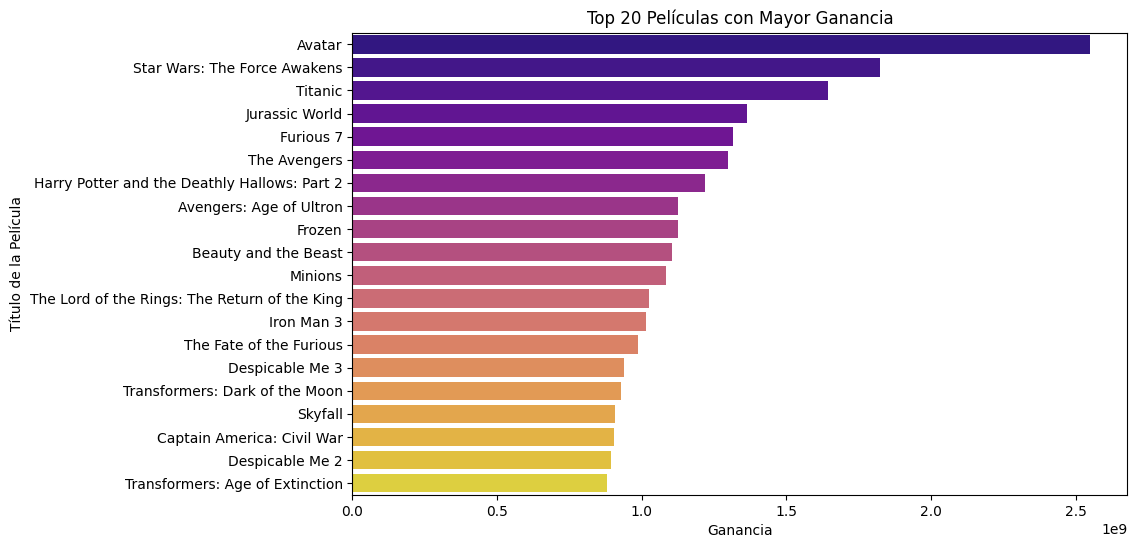

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x='profit', y='title', data=top_profit_movies, palette='plasma', hue='title')
plt.title('Top 20 Películas con Mayor Ganancia')
plt.xlabel('Ganancia')
plt.ylabel('Título de la Película')
plt.show()

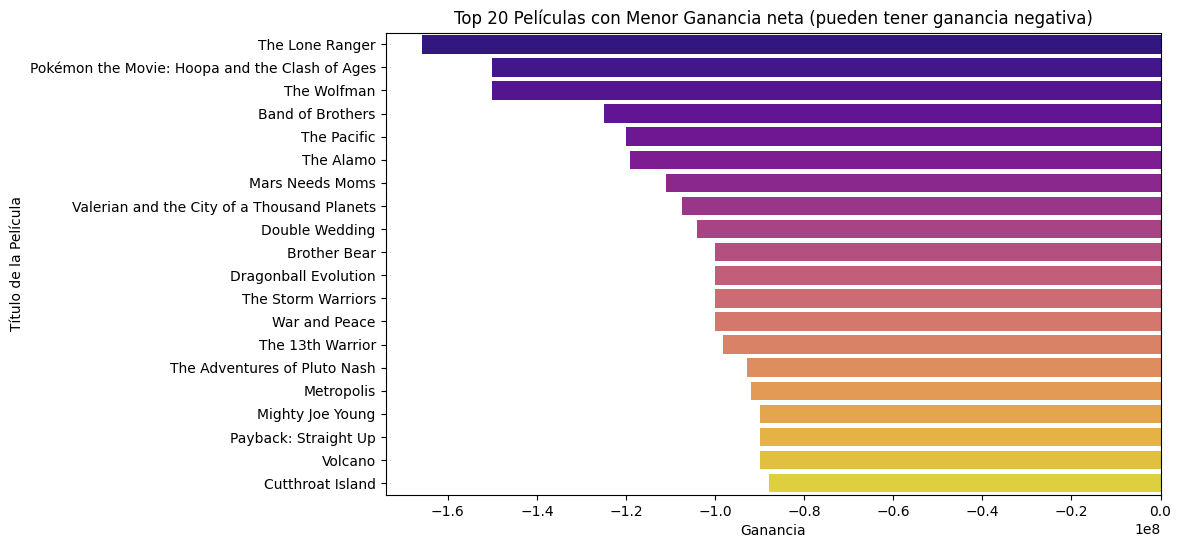

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='profit', y='title', data=bottom_profit_movies, palette='plasma', hue='title')
plt.title('Top 20 Películas con Menor Ganancia neta (pueden tener ganancia negativa)')
plt.xlabel('Ganancia')
plt.ylabel('Título de la Película')
plt.show()

In [47]:
# Filtrar películas con datos válidos
movies_filtered = movies.dropna(subset=['budget', 'revenue', 'popularity']).copy()
# Gananacia neta
movies_filtered.loc[:,'Net_Profit'] = movies_filtered['revenue'] - movies_filtered['budget']
# ROI
movies_filtered.loc[:,'return'] = movies_filtered['revenue'] / movies_filtered['budget']

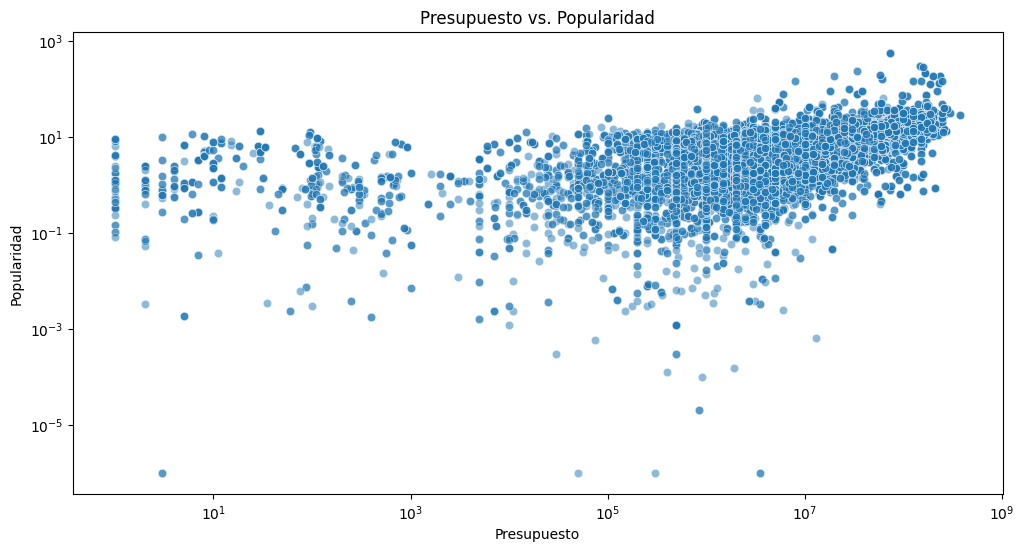

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='budget', y='popularity', data=movies_filtered, alpha=0.5)
plt.title('Presupuesto vs. Popularidad')
plt.xlabel('Presupuesto')
plt.ylabel('Popularidad')
plt.xscale('log')  # Para mejorar la visualización si hay grandes diferencias en el presupuesto
plt.yscale('log')  # Para mejorar la visualización si hay grandes diferencias en la popularidad
plt.show()

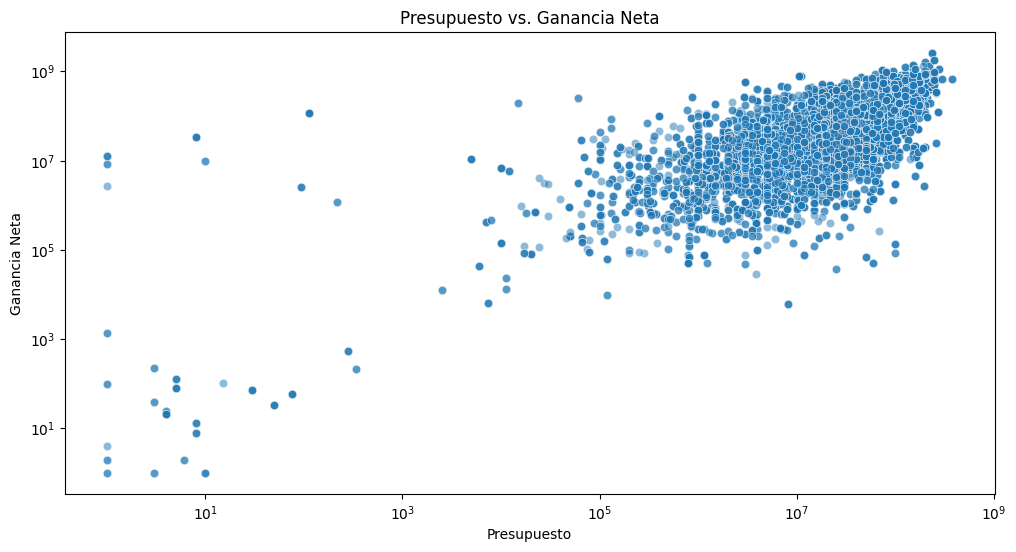

In [49]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='budget', y='Net_Profit', data=movies_filtered, alpha=0.5)
plt.title('Presupuesto vs. Ganancia Neta')
plt.xlabel('Presupuesto')
plt.ylabel('Ganancia Neta')
plt.xscale('log')  # Para mejorar la visualización si hay grandes diferencias en el presupuesto
plt.yscale('log')  # Para mejorar la visualización si hay grandes diferencias en la ganancia neta
plt.show()


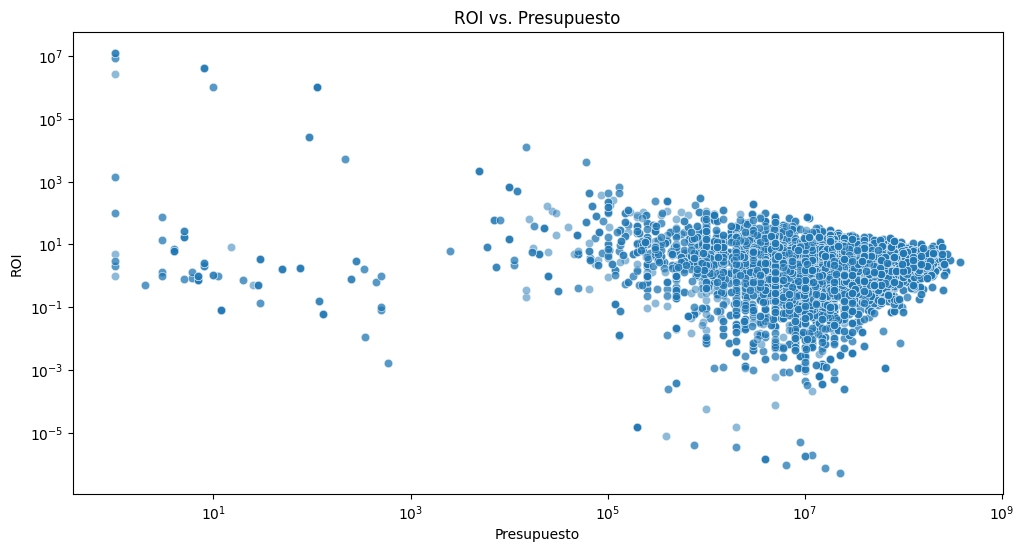

In [50]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='budget', y='return', data=movies_filtered, alpha=0.5)
plt.title('ROI vs. Presupuesto')
plt.xlabel('Presupuesto')
plt.ylabel('ROI')
plt.xscale('log')  # Para mejorar la visualización si hay grandes diferencias en el presupuesto
plt.yscale('log')  # Para mejorar la visualización si hay grandes diferencias en el ROI
plt.show()


## Analisis de Popularidad de peliculas

In [54]:
movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')
# Similar para popularidad
unique_movies = movies.drop_duplicates(subset='title')
top_popular_movies = unique_movies.nlargest(10, 'popularity')

# Asegurarnos de que 'release_date' esté en formato de fecha
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year

# Agrupar por año y calcular la popularidad media
popularity_by_year = movies.groupby('year')['popularity'].mean().reset_index()

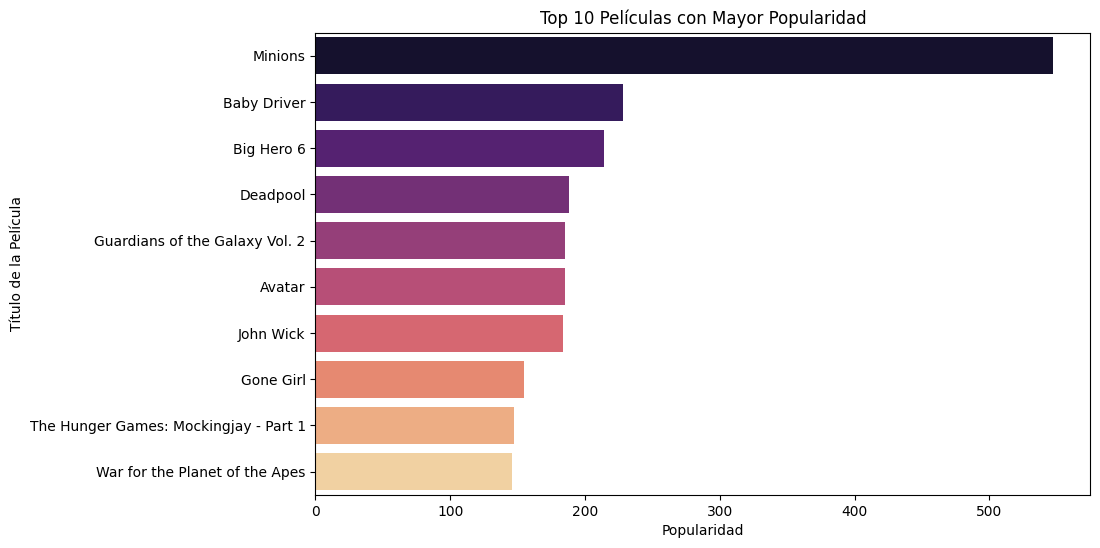

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='title', data=top_popular_movies, palette='magma', hue='title')
plt.title('Top 10 Películas con Mayor Popularidad')
plt.xlabel('Popularidad')
plt.ylabel('Título de la Película')
plt.show()

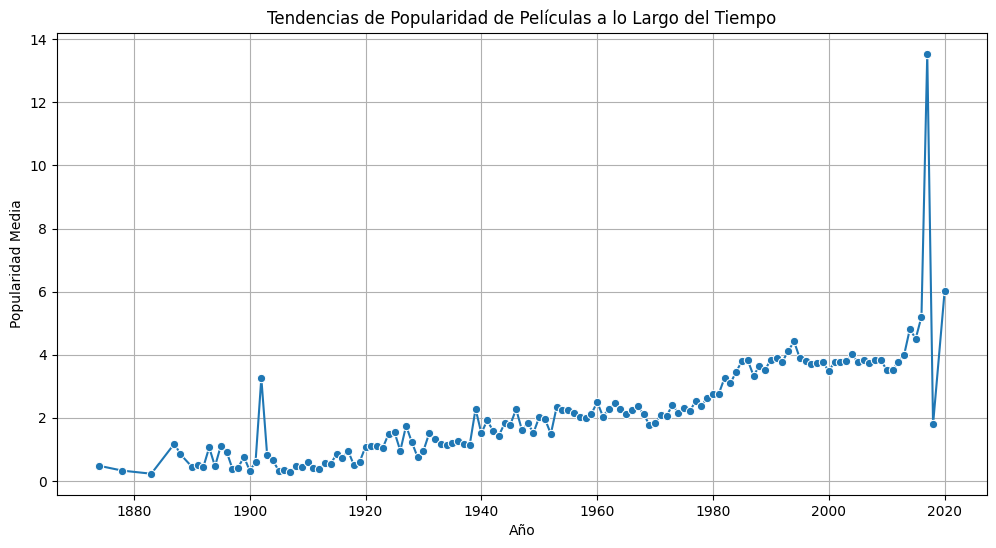

In [56]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='popularity', data=popularity_by_year, marker='o')
plt.title('Tendencias de Popularidad de Películas a lo Largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Popularidad Media')
plt.grid(True)
plt.show()

## Analisis Temporal

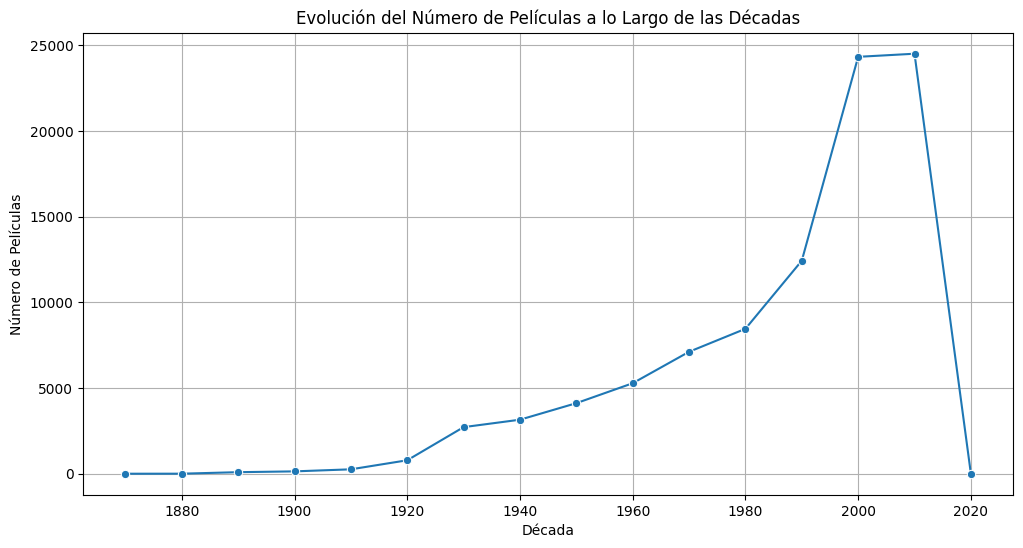

In [57]:
# Extraer el año y la década de la fecha de lanzamiento
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['year'] = movies['release_date'].dt.year
movies['decade'] = (movies['year'] // 10) * 10

# Agrupar por década y calcular el número de películas y presupuesto medio
movies_by_decade = movies.groupby('decade').agg({'title': 'count', 'budget': 'mean'}).reset_index()
movies_by_decade.columns = ['Decade', 'Number of Movies', 'Average Budget']

# Graficar el número de películas por década
plt.figure(figsize=(12, 6))
sns.lineplot(x='Decade', y='Number of Movies', data=movies_by_decade, marker='o')
plt.title('Evolución del Número de Películas a lo Largo de las Décadas')
plt.xlabel('Década')
plt.ylabel('Número de Películas')
plt.grid(True)
plt.show()

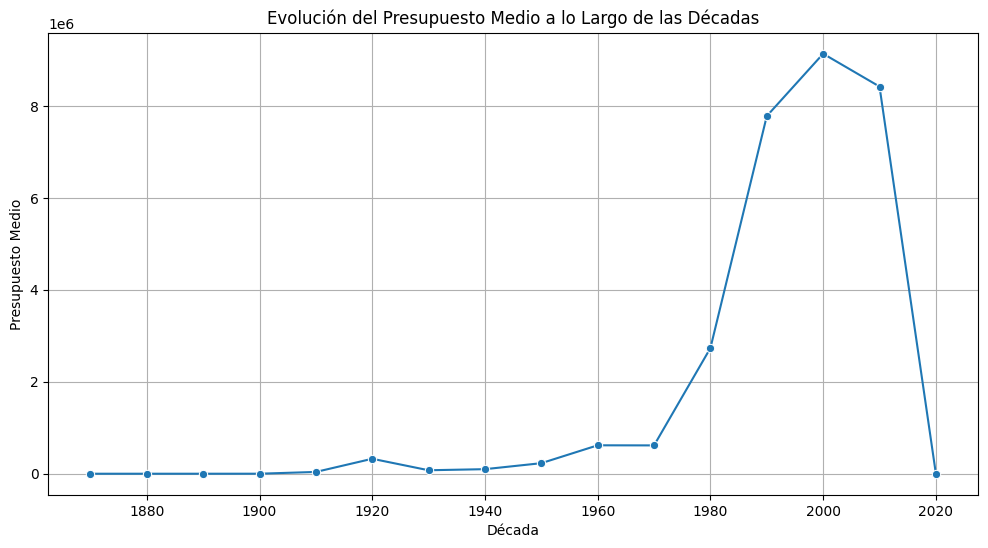

In [59]:
# Graficar el presupuesto medio por década
plt.figure(figsize=(12, 6))
sns.lineplot(x='Decade', y='Average Budget', data=movies_by_decade, marker='o')
plt.title('Evolución del Presupuesto Medio a lo Largo de las Décadas')
plt.xlabel('Década')
plt.ylabel('Presupuesto Medio')
plt.grid(True)
plt.show()

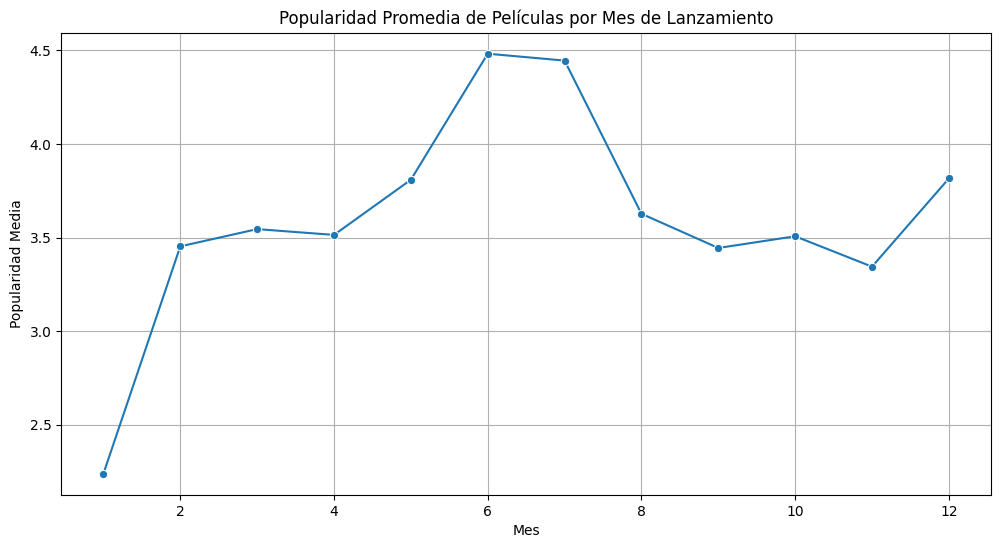

In [60]:
# Extraer el mes de la fecha de lanzamiento
movies['month'] = movies['release_date'].dt.month

# Agrupar por mes y calcular la popularidad media
popularity_by_month = movies.groupby('month')['popularity'].mean().reset_index()

# Graficar la popularidad media por mes
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='popularity', data=popularity_by_month, marker='o')
plt.title('Popularidad Promedia de Películas por Mes de Lanzamiento')
plt.xlabel('Mes')
plt.ylabel('Popularidad Media')
plt.grid(True)
plt.show()

## Analisis Directores y Actores

In [61]:
crew.head(2)

,budget,id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_year,return,genre_id,genre_name,department,gender,job,name
0,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,16.0,Animation,Directing,2.0,Director,John Lasseter
1,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,16.0,Animation,Writing,2.0,Screenplay,Joss Whedon


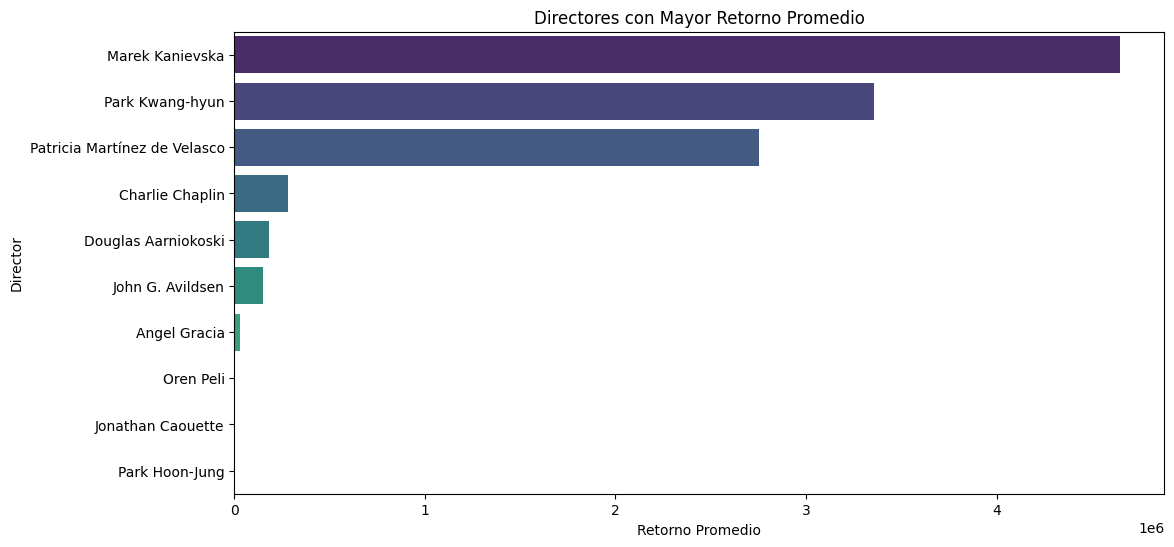

In [62]:
# Filtrar los directores en el DataFrame crew
directors = crew[crew['job'] == 'Director']

# Agrupar por director y calcular métricas
director_impact = directors.groupby('name').agg({'return': 'mean', 'return': 'mean'}).reset_index()

# Filtrar los directores con alto impacto
top_directors = director_impact.sort_values(by='return', ascending=False).head(10)

# Graficar los directores con mayor retorno
plt.figure(figsize=(12, 6))
sns.barplot(x='return', y='name', data=top_directors, palette='viridis', hue= 'name')
plt.title('Directores con Mayor Retorno Promedio')
plt.xlabel('Retorno Promedio')
plt.ylabel('Director')
plt.show()



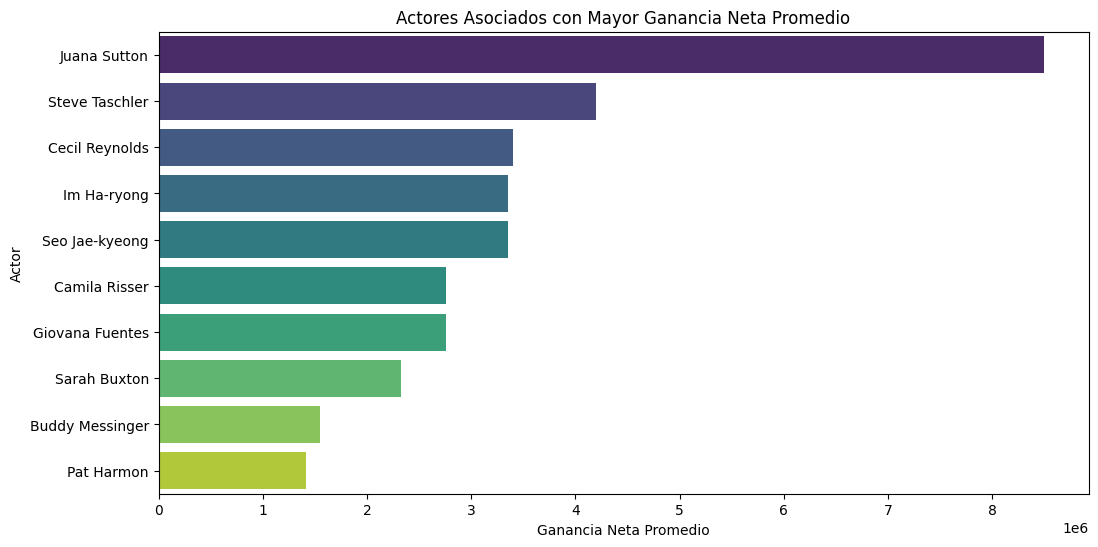

In [63]:
# Agrupar por actor y calcular métricas
actor_impact = casting.groupby('name').agg({'return': 'mean'}).reset_index()

# Filtrar los actores con alto impacto
top_actors = actor_impact.sort_values(by='return', ascending=False).head(10)

# Graficar los actores con mayor ganancia neta
plt.figure(figsize=(12, 6))
sns.barplot(x='return', y='name', data=top_actors, palette='viridis', hue= 'name')
plt.title('Actores Asociados con Mayor Ganancia Neta Promedio')
plt.xlabel('Ganancia Neta Promedio')
plt.ylabel('Actor')
plt.show()


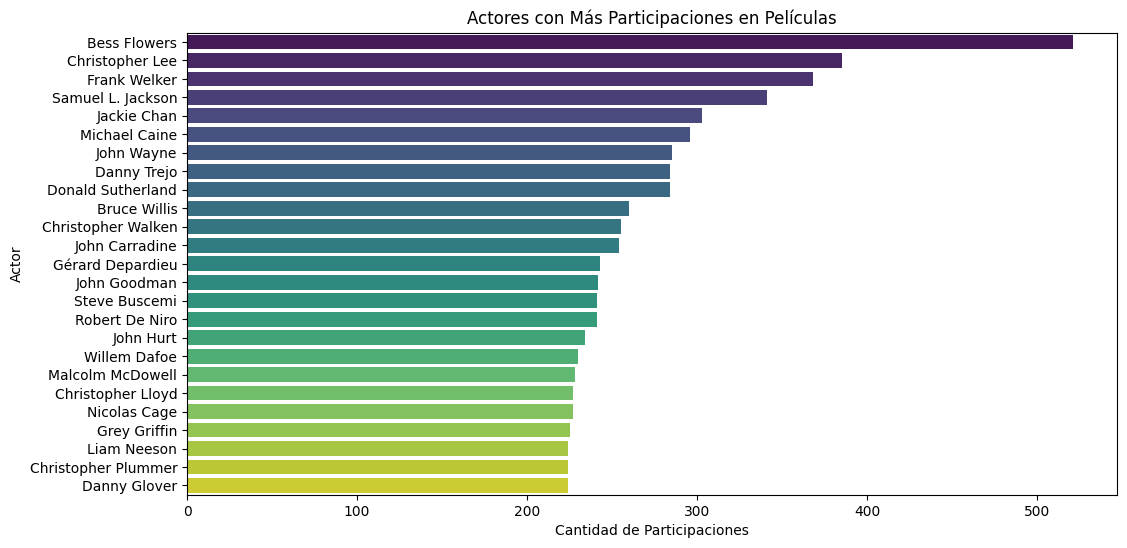

In [64]:
# Contar la cantidad de participaciones de cada actor
actor_counts = casting['name'].value_counts().reset_index()
actor_counts.columns = ['actor_name', 'participations']

# Filtrar los actores con más participaciones
top_actors_participation = actor_counts.head(25)

# Graficar los actores con más participaciones
plt.figure(figsize=(12, 6))
sns.barplot(x='participations', y='actor_name', data=top_actors_participation, palette='viridis', hue= 'actor_name')
plt.title('Actores con Más Participaciones en Películas')
plt.xlabel('Cantidad de Participaciones')
plt.ylabel('Actor')
plt.show()


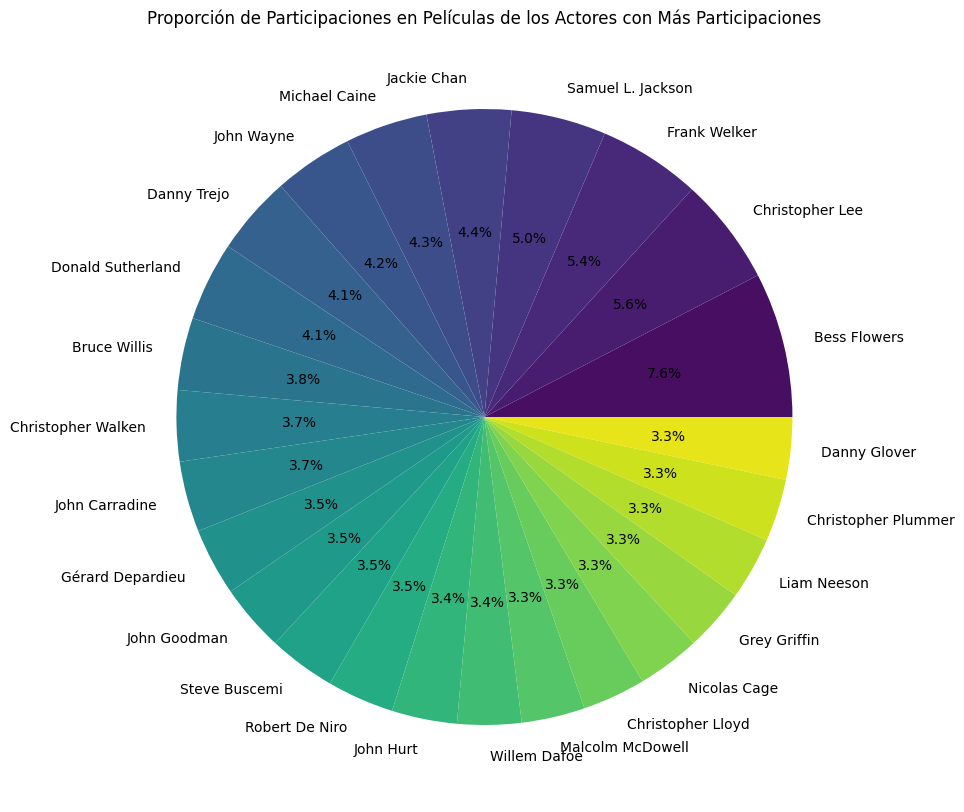

In [65]:
# Gráfico de torta para los actores con más participaciones
plt.figure(figsize=(20, 10))
plt.pie(top_actors_participation['participations'], labels=top_actors_participation['actor_name'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(top_actors_participation)))
plt.title('Proporción de Participaciones en Películas de los Actores con Más Participaciones')
plt.show()


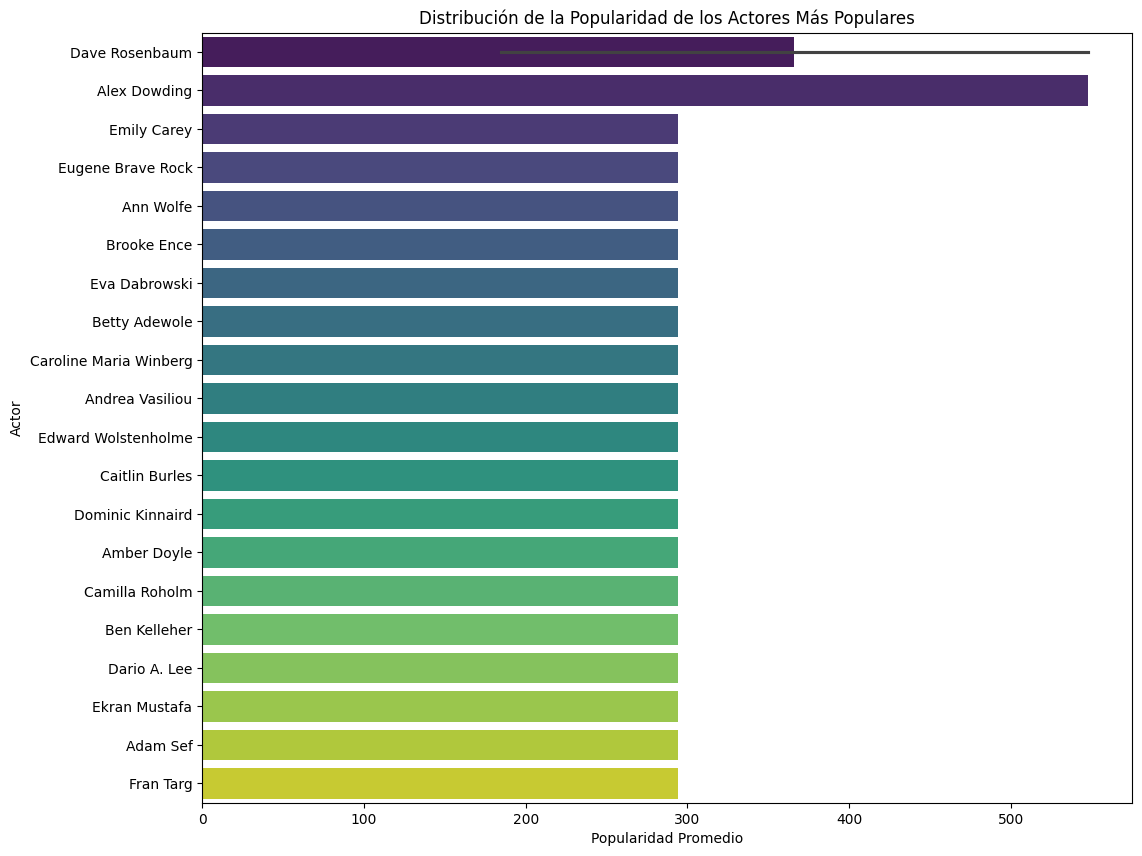

In [107]:
# Obtener los actores con mayor popularidad
top_actors = casting.groupby('name')['popularity'].mean().reset_index()
top_actors = top_actors.nlargest(20, 'popularity')

# a) Gráfico de Caja (Box Plot)
plt.figure(figsize=(12, 10))
sns.barplot(x='popularity', y='name', data=casting[casting['name'].isin(top_actors['name'])], palette='viridis', hue='name')
plt.title('Distribución de la Popularidad de los Actores Más Populares')
plt.xlabel('Popularidad Promedio')
plt.ylabel('Actor')
plt.show()

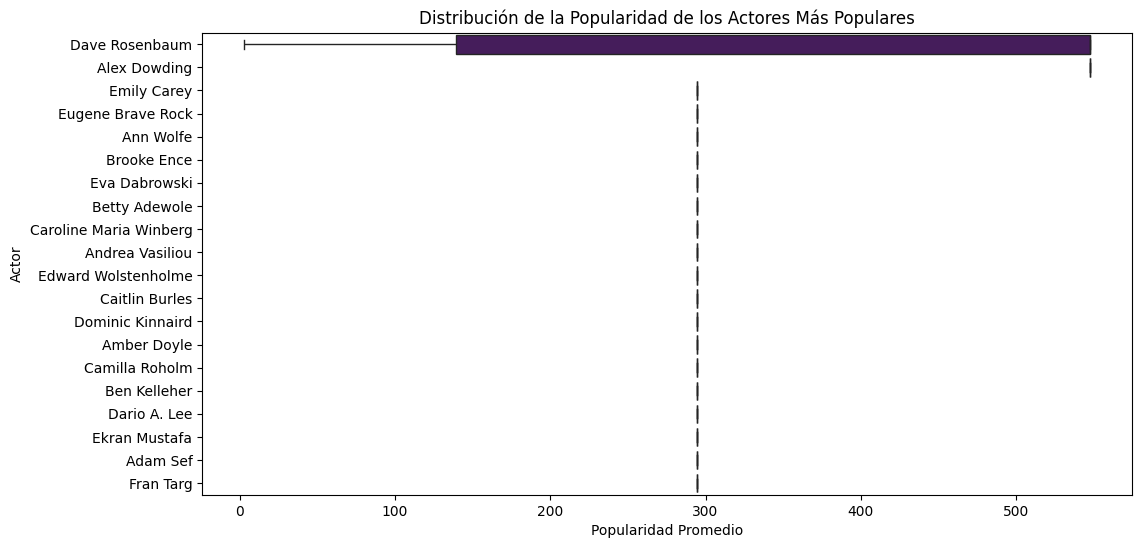

In [106]:
# b) Gráfico de Violín (Violin Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='popularity', y='name', data=casting[casting['name'].isin(top_actors['name'])], palette='viridis', hue='name')
plt.title('Distribución de la Popularidad de los Actores Más Populares')
plt.xlabel('Popularidad Promedio')
plt.ylabel('Actor')
plt.show()

## Analisis de Tiulos

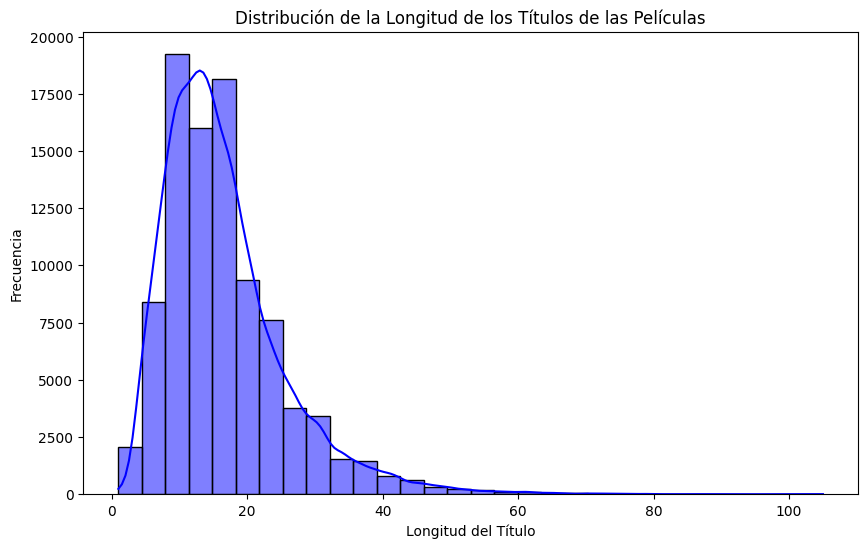

In [108]:
# Eliminar filas donde 'title' es None o NaN
movies = movies.dropna(subset=['title'])

# Calcular la longitud de los títulos
movies['title_length'] = movies['title'].apply(len)

# Visualizar la distribución de la longitud de los títulos
plt.figure(figsize=(10, 6))
sns.histplot(movies['title_length'], kde=True, bins=30, color='blue')
plt.title('Distribución de la Longitud de los Títulos de las Películas')
plt.xlabel('Longitud del Título')
plt.ylabel('Frecuencia')
plt.show()

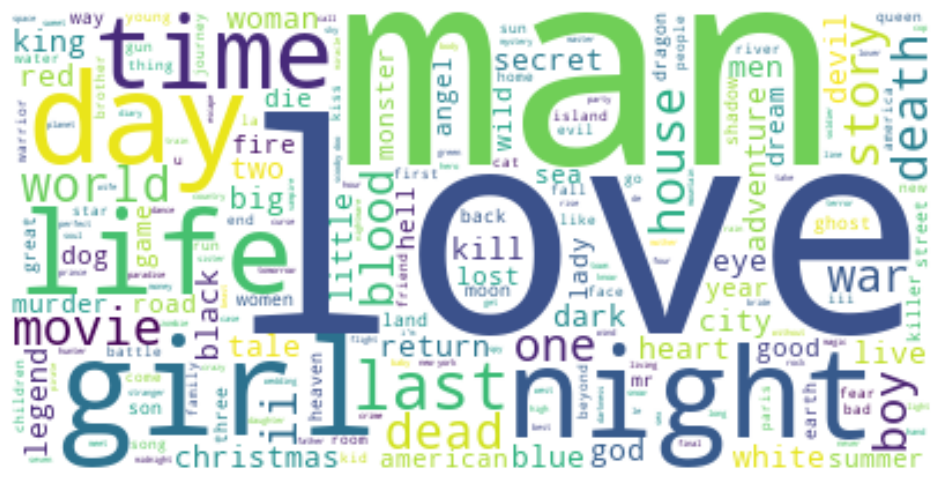

In [109]:
# Crear una sola cadena de texto con todos los títulos
text = ' '.join(movies['title'].str.lower())

# Generar la nube de palabras
wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [122]:
movies.head()

,budget,id_movie,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_year,return,genre_id,genre_name,z_score,profit,year,decade,month,title_length
0,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,16.0,Animation,4.493184,343554033.0,1995,1990,10,9
1,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,35.0,Comedy,4.493184,343554033.0,1995,1990,10,9
2,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,10751.0,Family,4.493184,343554033.0,1995,1990,10,9
3,65000000.0,8844,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995,4.043035,12.0,Adventure,3.101584,197797249.0,1995,1990,12,7
4,65000000.0,8844,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,1995,4.043035,14.0,Fantasy,3.101584,197797249.0,1995,1990,12,7


## Analisis por Genero

In [123]:
# Agrupar por género y calcular la ganancia neta total
genre_profit = movies.groupby('genre_name')['profit'].sum().reset_index()

# Ordenar por ganancia neta en orden descendente
top_genre_profit = genre_profit.sort_values(by='profit', ascending=False)


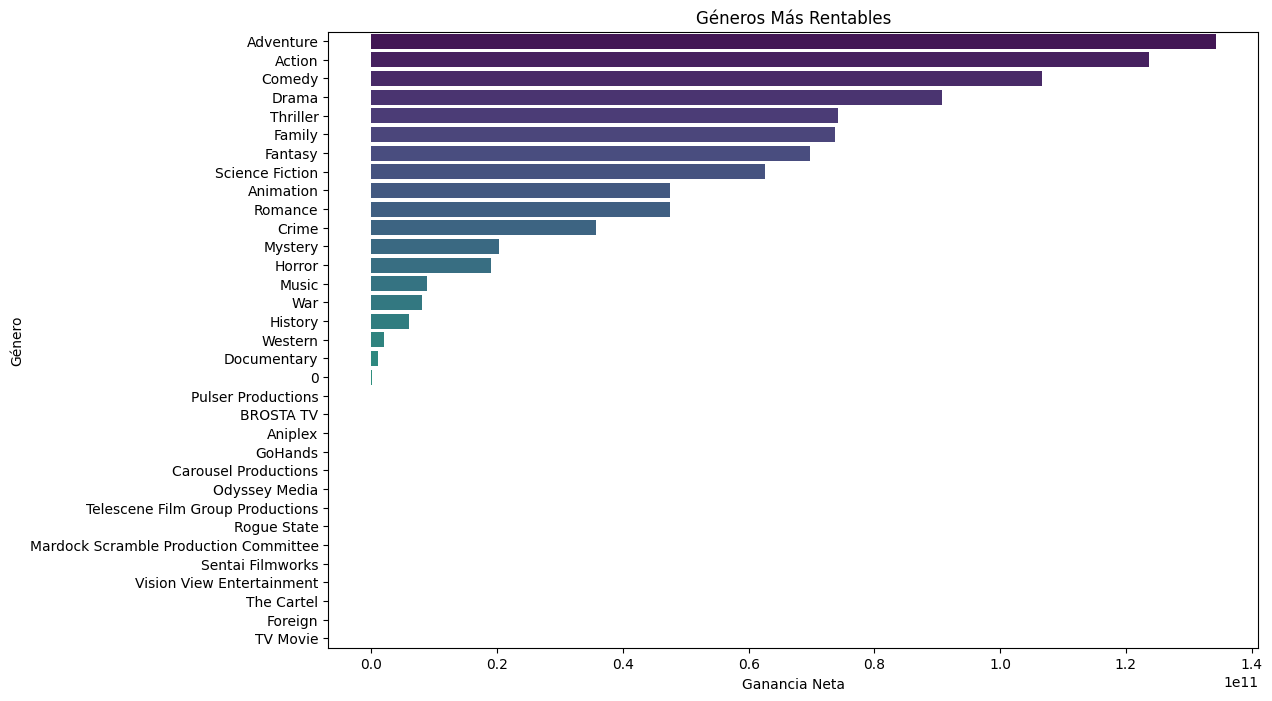

In [125]:
plt.figure(figsize=(12, 8))
sns.barplot(x='profit', y='genre_name', data=top_genre_profit, palette='viridis', hue='genre_name')
plt.title('Géneros Más Rentables')
plt.xlabel('Ganancia Neta')
plt.ylabel('Género')
plt.show()

In [126]:
# Agrupar por género y calcular la popularidad promedio
genre_popularity = movies.groupby('genre_name')['popularity'].mean().reset_index()

# Ordenar por popularidad en orden descendente
top_genre_popularity = genre_popularity.sort_values(by='popularity', ascending=False)

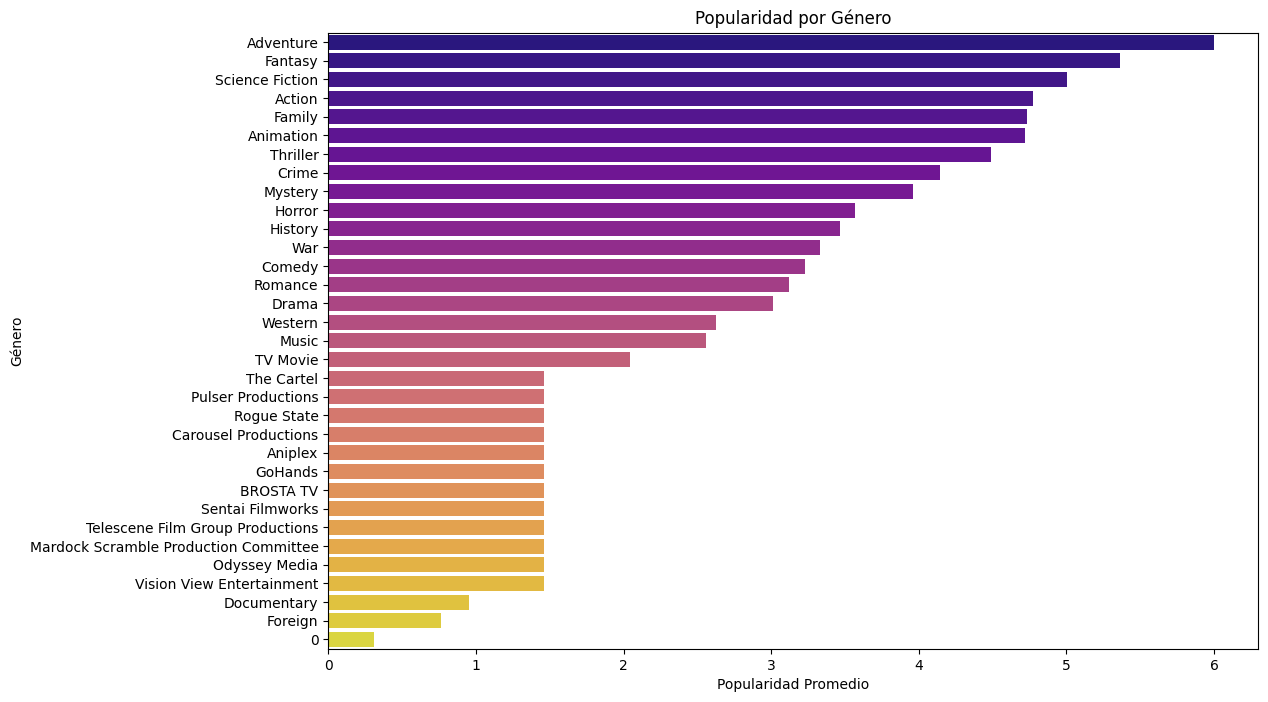

In [128]:
plt.figure(figsize=(12, 8))
sns.barplot(x='popularity', y='genre_name', data=top_genre_popularity, palette='plasma', hue='genre_name')
plt.title('Popularidad por Género')
plt.xlabel('Popularidad Promedio')
plt.ylabel('Género')
plt.show()


In [129]:
# Agrupar por género y calcular el presupuesto promedio
genre_budget = movies.groupby('genre_name')['budget'].mean().reset_index()

# Ordenar por presupuesto en orden descendente
top_genre_budget = genre_budget.sort_values(by='budget', ascending=False)

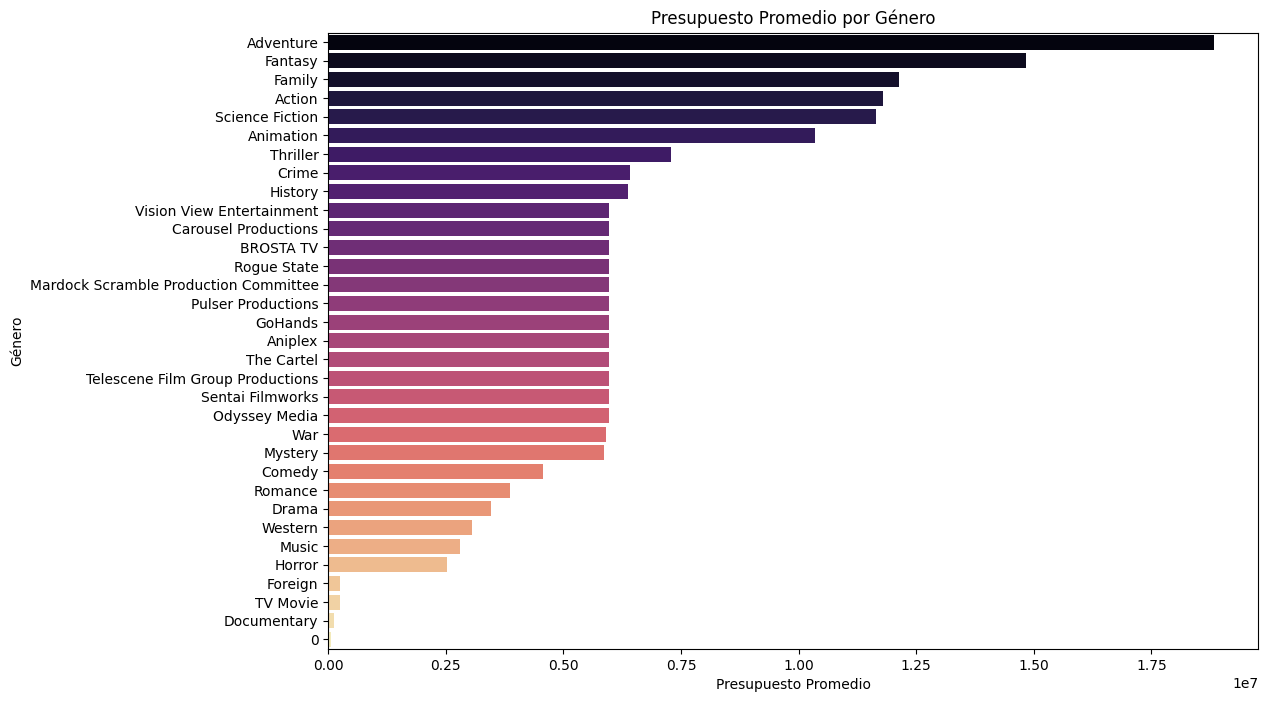

In [131]:
plt.figure(figsize=(12, 8))
sns.barplot(x='budget', y='genre_name', data=top_genre_budget, palette='magma', hue='genre_name')
plt.title('Presupuesto Promedio por Género')
plt.xlabel('Presupuesto Promedio')
plt.ylabel('Género')
plt.show()

 ## Analisis de Correlacion

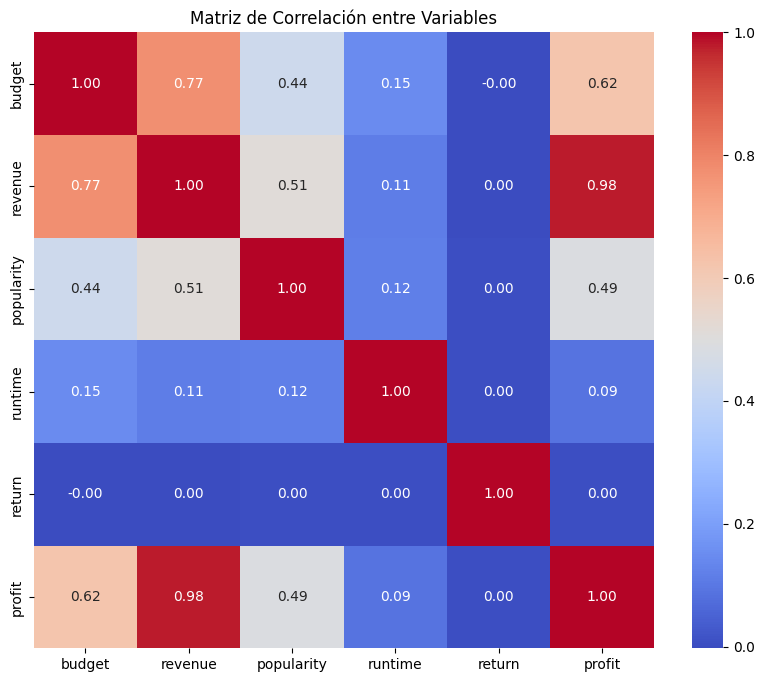

In [110]:
# Seleccionar las columnas relevantes para el análisis de correlación
columns_of_interest = ['budget', 'revenue', 'popularity', 'runtime', 'return', 'profit']

# Calcular la matriz de correlación
correlation_matrix = movies[columns_of_interest].corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.show()


In [111]:
# Seleccionar las columnas relevantes para el análisis de regresión
regression_data = movies[['budget', 'revenue', 'popularity', 'runtime', 'return', 'profit']].dropna()

# Separar variables independientes y dependientes
X = regression_data[['budget', 'runtime', 'popularity']]  # Variables independientes
y = regression_data['revenue']  # Variable dependiente


In [112]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores para el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Coeficientes del modelo
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 2121825030202964.25
R-squared: 0.63
             Coefficient
budget      2.570128e+00
runtime    -2.834057e+04
popularity  2.462415e+06


In [113]:
# Rellenar los valores nulos de las columnas budget, revenue, popularity y runtime con la mediana de cada columna.
movies_cleaned = movies.fillna({
    'budget': movies['budget'].median(),
    'revenue': movies['revenue'].median(),
    'popularity': movies['popularity'].median(),
    'runtime': movies['runtime'].median()
})

In [114]:
# Calcular el rango intercuartílico para cada columna
Q1 = movies_cleaned[['budget', 'revenue', 'popularity', 'runtime']].quantile(0.25)
Q3 = movies_cleaned[['budget', 'revenue', 'popularity', 'runtime']].quantile(0.75)
IQR = Q3 - Q1

# Filtrar los outliers
movies_filtered = movies_cleaned[~((movies_cleaned[['budget', 'revenue', 'popularity', 'runtime']] < (Q1 - 1.5 * IQR)) | (movies_cleaned[['budget', 'revenue', 'popularity', 'runtime']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [115]:
# Seleccionar las columnas para la regresión
X = movies_filtered[['budget', 'runtime', 'popularity']]
y = movies_filtered['revenue']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Crear el modelo de regresión lineal
model = LinearRegression()

# Evaluar el modelo con validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convertir los puntajes negativos a positivos
mse_scores = -cv_scores
mean_mse = mse_scores.mean()
print(f'Mean Cross-Validated MSE: {mean_mse:.2f}')

# Ajustar el modelo en el conjunto de entrenamiento
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f'Test Mean Squared Error: {mse_test:.2f}')
print(f'Test R-squared: {r2_test:.2f}')


Mean Cross-Validated MSE: 0.00
Test Mean Squared Error: 0.00
Test R-squared: 1.00


In [117]:
movies.head(1)

,budget,id_movie,popularity,release_date,revenue,runtime,title,vote_average,vote_count,release_year,return,genre_id,genre_name,z_score,profit,year,decade,month,title_length
0,30000000.0,862,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,1995,12.451801,16.0,Animation,4.493184,343554033.0,1995,1990,10,9


# Nube de palabras

In [118]:
# Eliminar filas donde 'title' es None o NaN
movies = movies.dropna(subset=['title'])
# Combinamos todos los titulos en un texto largo
all_titles = ' '.join(movies['title'].dropna().tolist())

In [119]:
# Generamos la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, stopwords=None).generate(all_titles)

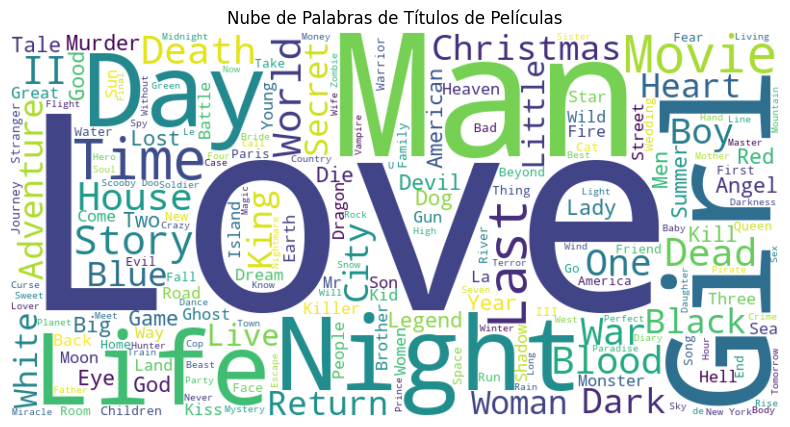

In [120]:
# Graficamos la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Títulos de Películas')
plt.show()